# 목차

* 평가문항
* 데이터 정제 및 토큰화
* 모델 설계
* 모듈 조립하기
* 학습하기
* 회고
* Reference

# 평가문항

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

---

평가문항	상세기준

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.

> 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

2. Transformer 번역기 모델이 정상적으로 구동된다.

> Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.

3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.

> 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn as sns # Attention 시각화를 위해 필요!

In [ ]:
# 한글 폰트를 시각화하는 코드

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


# 데이터 정제 및 토큰화

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [ ]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

위 코드에서 se()을 통해 중복 데이터를 없앤다. zip()으로 두 데이터를 합친 후 set()을 적용하고, 다시 list()를 통해 타입을 리스트로 바꿔준다.

In [ ]:
print("Data Size:", len(cleaned_corpus))
print("Example:")

for sen in cleaned_corpus[0:5]: print(">>", sen)

Data Size: 78968
Example:
>> ('20세의 라파엘 나달은 클레이코트에서 81연승을 올리다 지난달 열린 함부르크 대회 결승전에서 로저 페더러(스위스)에 패해 기록이 끊겼다.', '20-year-old Nadal, whose 81-match streak on clay was ended by Roger Federer in the Hamburg final earlier this month, slowed down a bit after an early break but did enough to stay in control until he earned three match points.')
>> ('톰슨은 다른 경쟁자들이 후보 등록을 마치고 선거자금을 모금하기 시작한 후인 지난해 9월 대선 레이스에 뛰어들었다.', 'Thompson entered the race in September, long after his Republican rivals had announced their candidacies and began raising money.')
>> ('마카오는 작년에만 관광객 2,200만명을 유치, 2005년 대비 17% 성장한 모습을 보였다.', 'After the former Portuguese enclave of Macau opened up to the big U.S. casino firms, it proved so popular that its annual gambling revenues hit US$7 billion last year.')
>> ('총격으로 인해 사망한 사람은 커널 리홉슨(43), 인텐슨 리홉슨(44), 제시 코시아(53)등 3명이다.', 'Five people were wounded in the Sunday afternoon attack at the church in Neosho, about 120 miles northeast of Tulsa, Oklahoma.')
>> ('인신매매는 성 행위를 목적으로 여성이 이곳 저

In [ ]:
cleaned_corpus[0][0]

'20세의 라파엘 나달은 클레이코트에서 81연승을 올리다 지난달 열린 함부르크 대회 결승전에서 로저 페더러(스위스)에 패해 기록이 끊겼다.'

In [ ]:
def preprocess_sentence(sentence):
    
    # 모든 입력은 소문자로 변환
    sentence = sentence.lower()
    
    # 영어, 한글, 일부 문장부호만를 제외한 나머지 제거
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ.,?!]+", " ", sentence)
    
    # 문장부호 좌우에 공백 추가
    sentence = re.sub(r"([,.?!])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

In [ ]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    # corpus를 받아 txt 파일로 저장
    temp_file = os.getenv('HOME')+'/aiffel/transformer/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for i in range(len(cleaned_corpus)):
    k, e = cleaned_corpus[i][0] , cleaned_corpus[i][1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/corpus_{lang}.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/corpus_{lang}.txt
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_

True

_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 82992 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 78956
trainer_interface.cc(537) LOG(INFO) Done! 44562
unigram_model_trainer.cc(489) LOG(INFO) Using 44562 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=34535 obj=9.86221 num_tokens=83351 num_tokens/piece=2.41352
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=25851 obj=8.00619 num_tokens=83809 num_tokens/piece=3.242
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=21977 obj=7.92346 num_tokens=84668 num_tokens/piece=3.85257
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=21848 obj=7.90465 num_tokens=84910 num_tokens/piece=3.8864
trainer_interface.cc(615) LOG(INFO) Saving model: spm_en.model
trainer_interface.cc(626) LOG(INFO) Saving 

토크나이저로 센텐스피스 사용, 단어장의 크기는 2만개로 둔다.

In [ ]:
# 토큰의 길이가 50 이하인 문장만 사용하자.

from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

토큰의 길이가 50 이하인 문장만을 코퍼스 리스트에 추가한다.

이후 패딩처리를 해 모든 코퍼스의 길이를 50으로 맞춘다.

In [ ]:
np.shape(enc_train)

(72143, 50)

# 모델 설계

## 포지셔널 인코딩

In [ ]:
# Positional encoding

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

## 멀티헤드 어텐션

In [ ]:
# Multihead attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

## 포지션-와이즈 피드 포워드

In [ ]:
# Position-wise Feed-Forward Network

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

# 모듈 조립하기

## Encoder 레이어 구현하기

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

## Decoder 레이어 구현하기

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## 인코더, 디코더 클래스

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer 완성하기

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 마스킹, 학습률

In [ ]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


# 학습하기

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff = 2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared=True
)

위 값은 논문에 설명된 값에 기초하여 대입한다.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 학습실시

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_32/3784166017.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is the same time .
Input: 커피는 필요 없다.
Predicted translation: it is not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is a key .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of urban cities are in the city of the city .
Input: 커피는 필요 없다.
Predicted translation: but the coffee is not  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll from .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s mountainous mountain .
Input: 커피는 필요 없다.
Predicted translation: it is not a good time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the dead .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama s right .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the most commonplace .
Input: 커피는 필요 없다.
Predicted translation: but it s not known .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , killing people dead and wounds .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a big message .
Input: 커피는 필요 없다.
Predicted translation: it s necessary , he said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six seven people were killed on monday , the death tolls in the day .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is about miles away .
Input: 커피는 필요 없다.
Predicted translation: the coffee is a good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the seven dead .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is weighing in at the presidential poll .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens of the city s cities are mounting .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were wounded .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is what is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city of new cities is in the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is director for the rights group .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people received seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is what is being the president is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in one city , cities is in grave .
Input: 커피는 필요 없다.
Predicted translation: coffee no need for coffee is
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven fatalities seven seven seven florida fatalities on the day of the victim of the seven fatalities .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is picked up .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city , people will take place .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not need to put off on coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the day .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city is in cha streets .
Input: 커피는 필요 없다.
Predicted translation: the coffee is director monday .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven florida s seven deaths were reported killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is what is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city is in the streets .
Input: 커피는 필요 없다.
Predicted translation: the drink need to need for medical consequences .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven dead were killed and , with seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s pickup is heading to iraq .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city , yes , we yes .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs to take coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and the deaths of the seven dead .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is uh , .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens of the city s cities are in the streets .
Input: 커피는 필요 없다.
Predicted translation: the practice needs to eat .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven received seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is uh , who get the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of chiang city is in the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee need for coffee is real .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is uh , mccain .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city , somebody is in cities .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs strong coffee , noro said . needs to take even coffee with its needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven received seven deaths on monday , with seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is ready .
Input: 시민들은 도시 속에 산다.
Predicted translation: in all areas
Input: 커피는 필요 없다.
Predicted translation: the drink shouldn t be need for , smoking needs to be safe , need for the need for stronger .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were in seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is scheduled to make him .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city of one in the great city is in the cities .
Input: 커피는 필요 없다.
Predicted translation: even if coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were wounded .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city for the great city .
Input: 커피는 필요 없다.
Predicted translation: the drink need for medical needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven received seven people , deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential poll .
Input: 시민들은 도시 속에 산다.
Predicted translation: they wouldn ban all cities in cities .
Input: 커피는 필요 없다.
Predicted translation: the practice needs to flight .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people received seven deaths .


Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential poll .
Encoder Layer 1


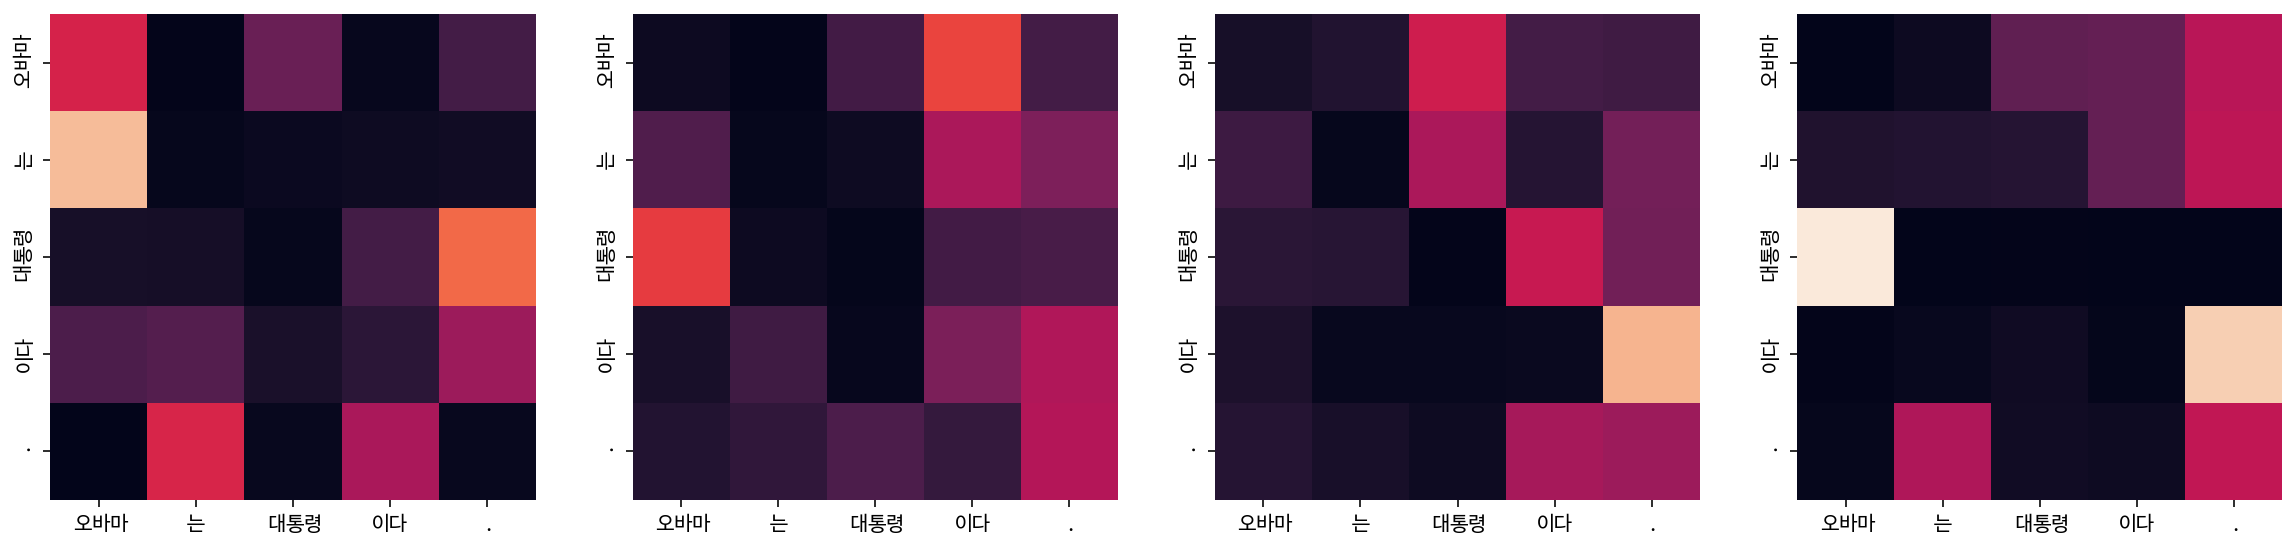

Encoder Layer 2


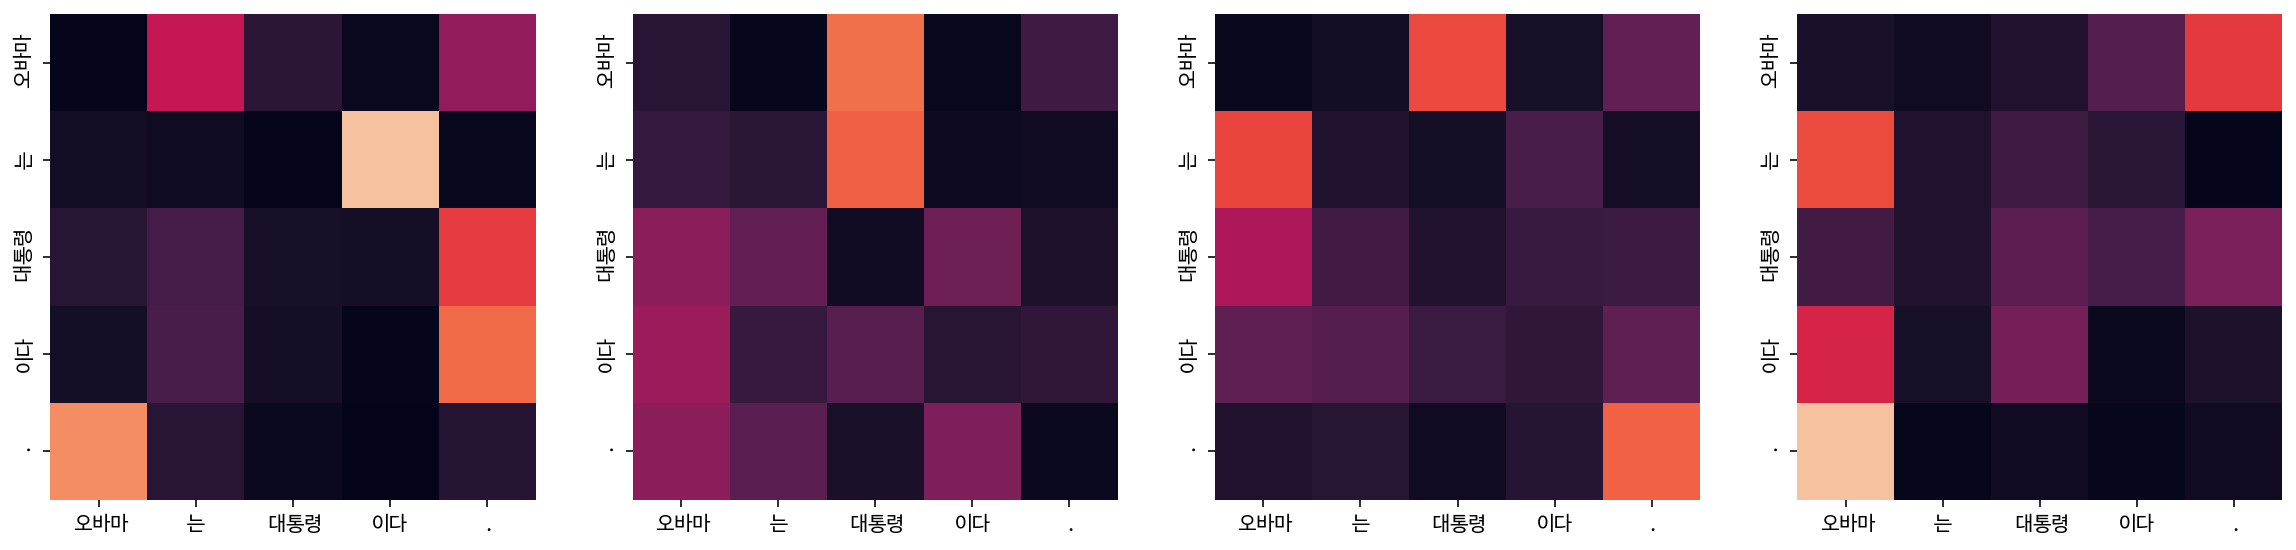

Decoder Self Layer 1


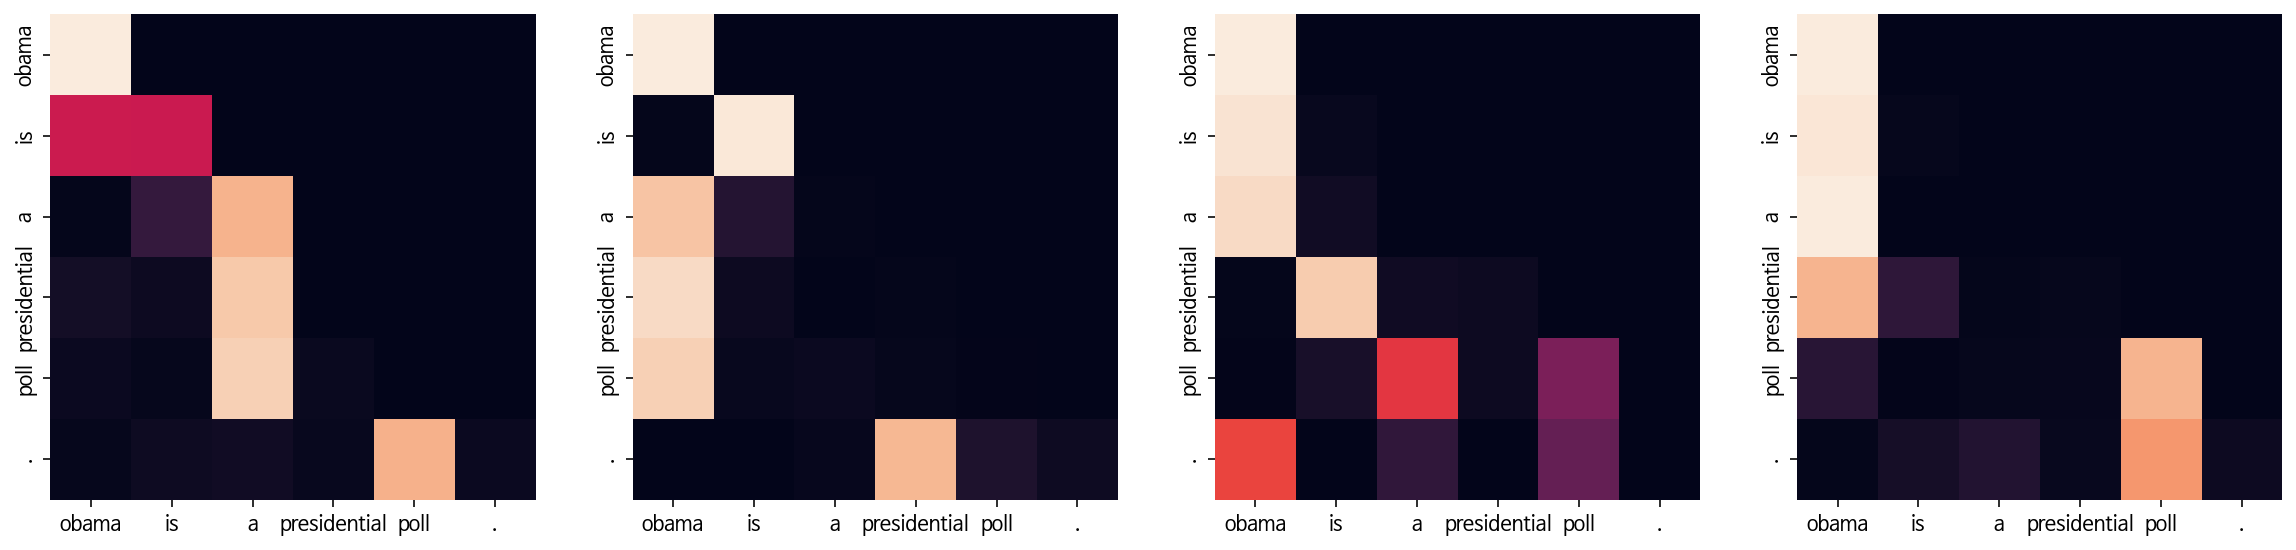

Decoder Src Layer 1


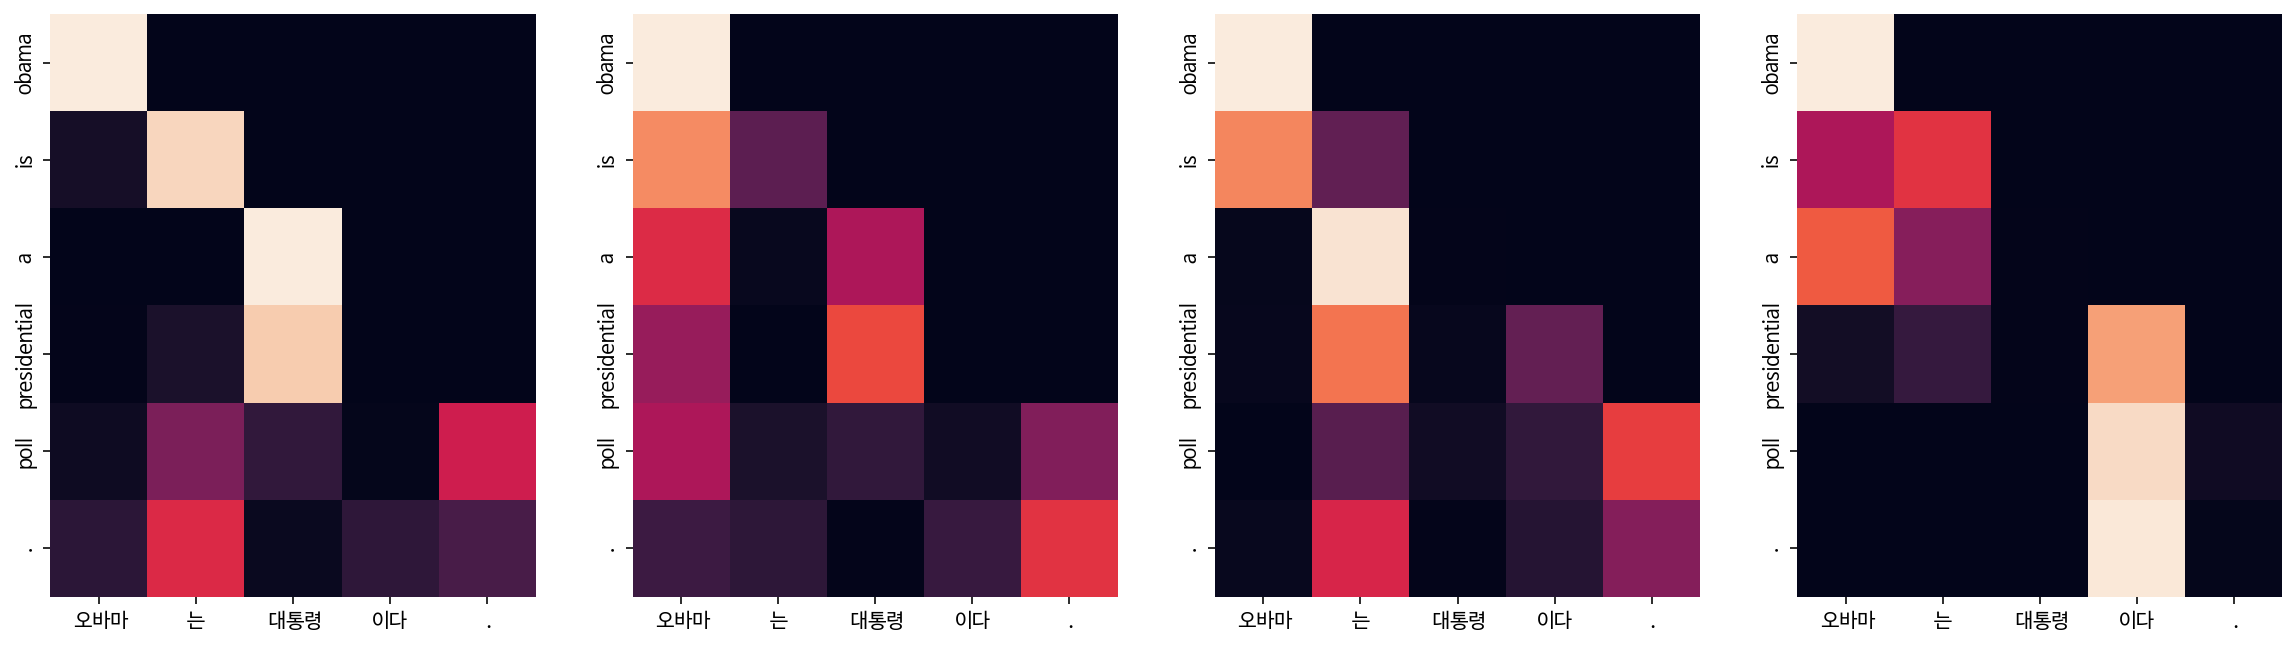

Decoder Self Layer 2


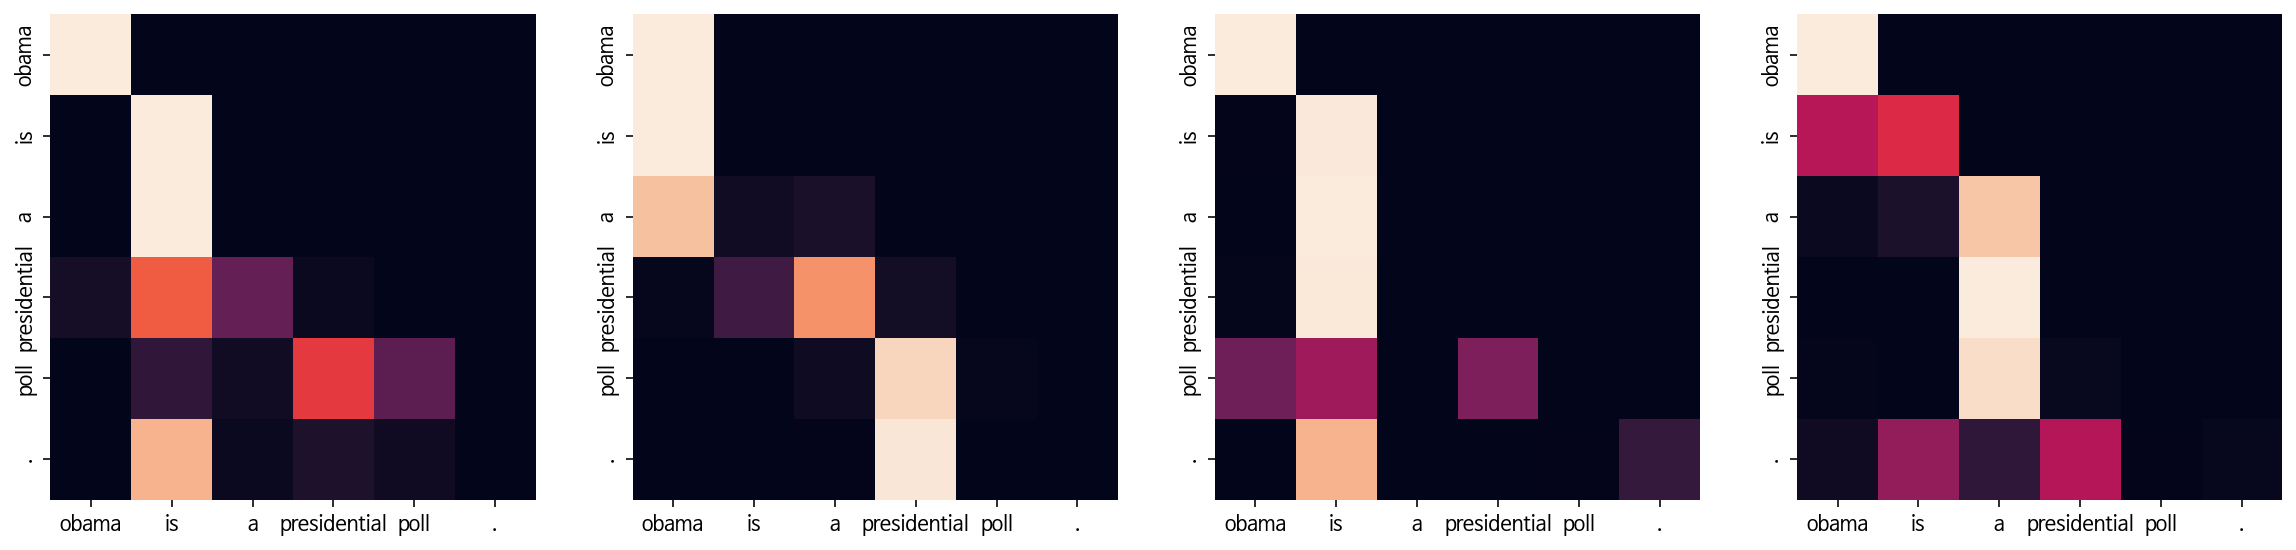

Decoder Src Layer 2


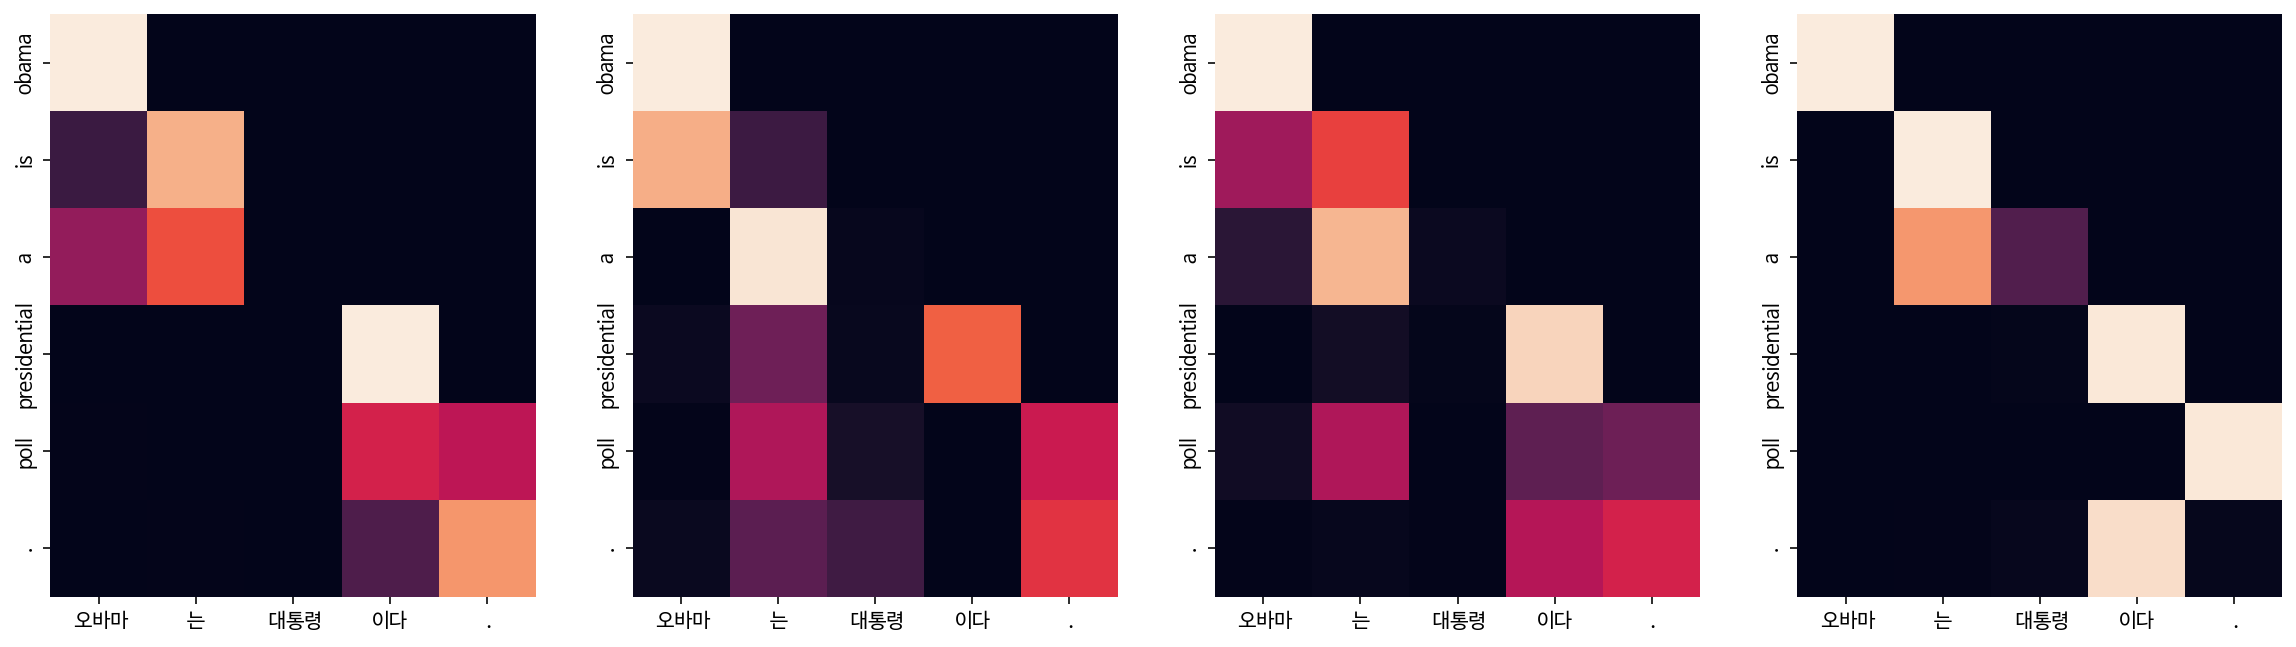

Input: 시민들은 도시 속에 산다.
Predicted translation: they wouldn ban all cities in cities .
Encoder Layer 1


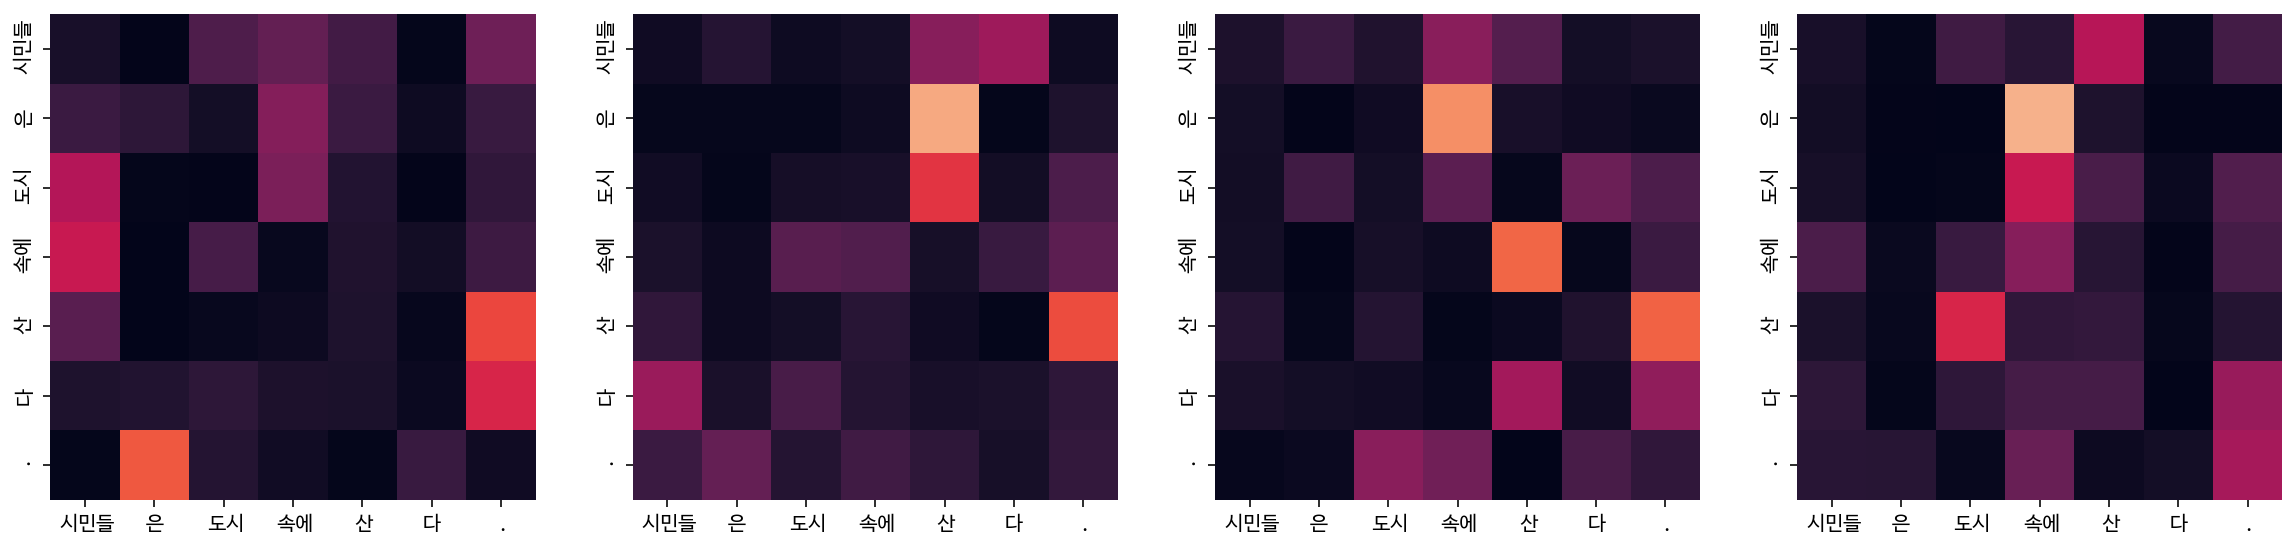

Encoder Layer 2


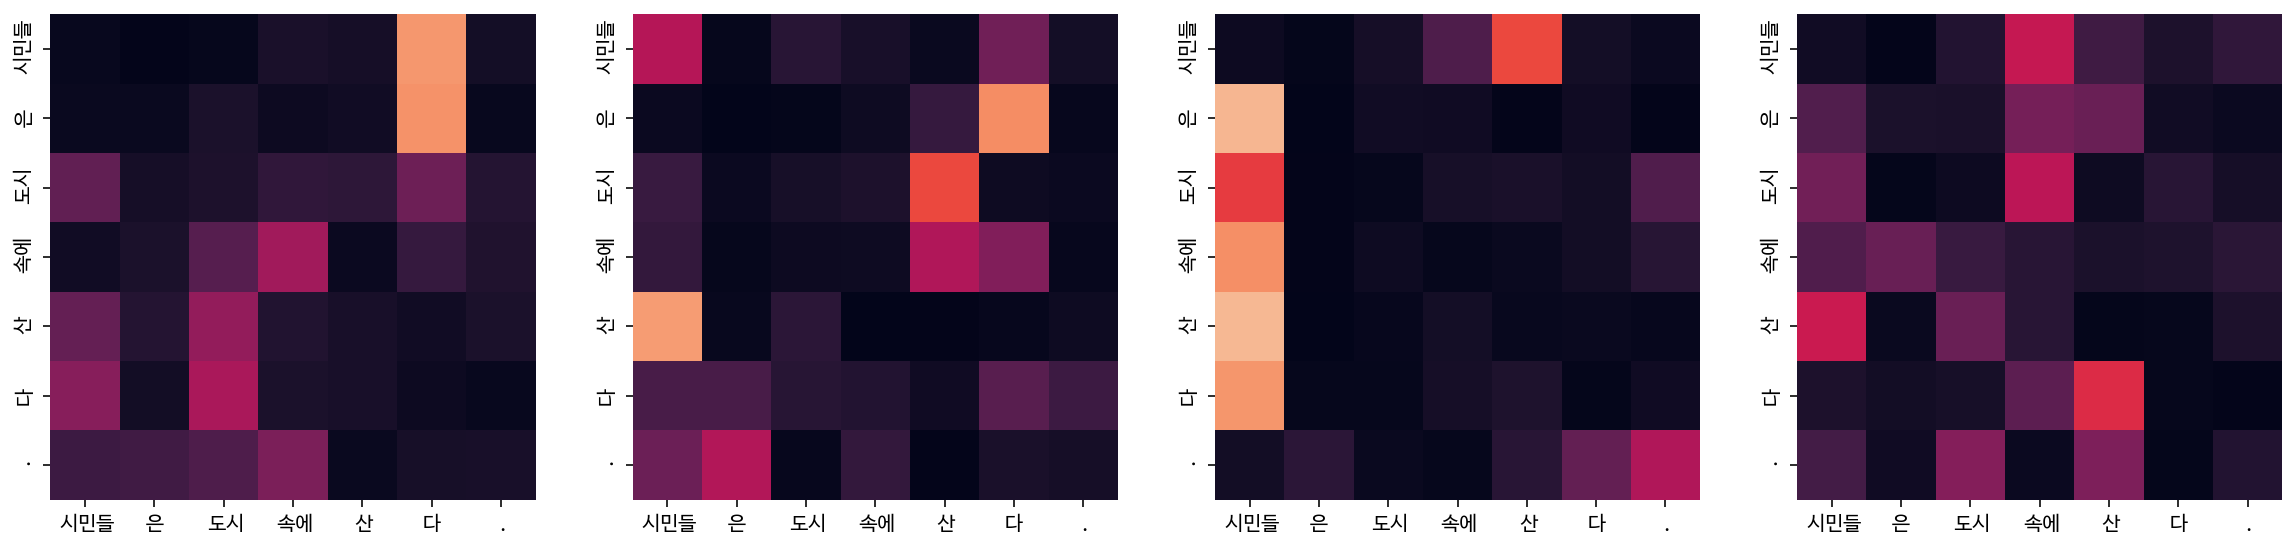

Decoder Self Layer 1


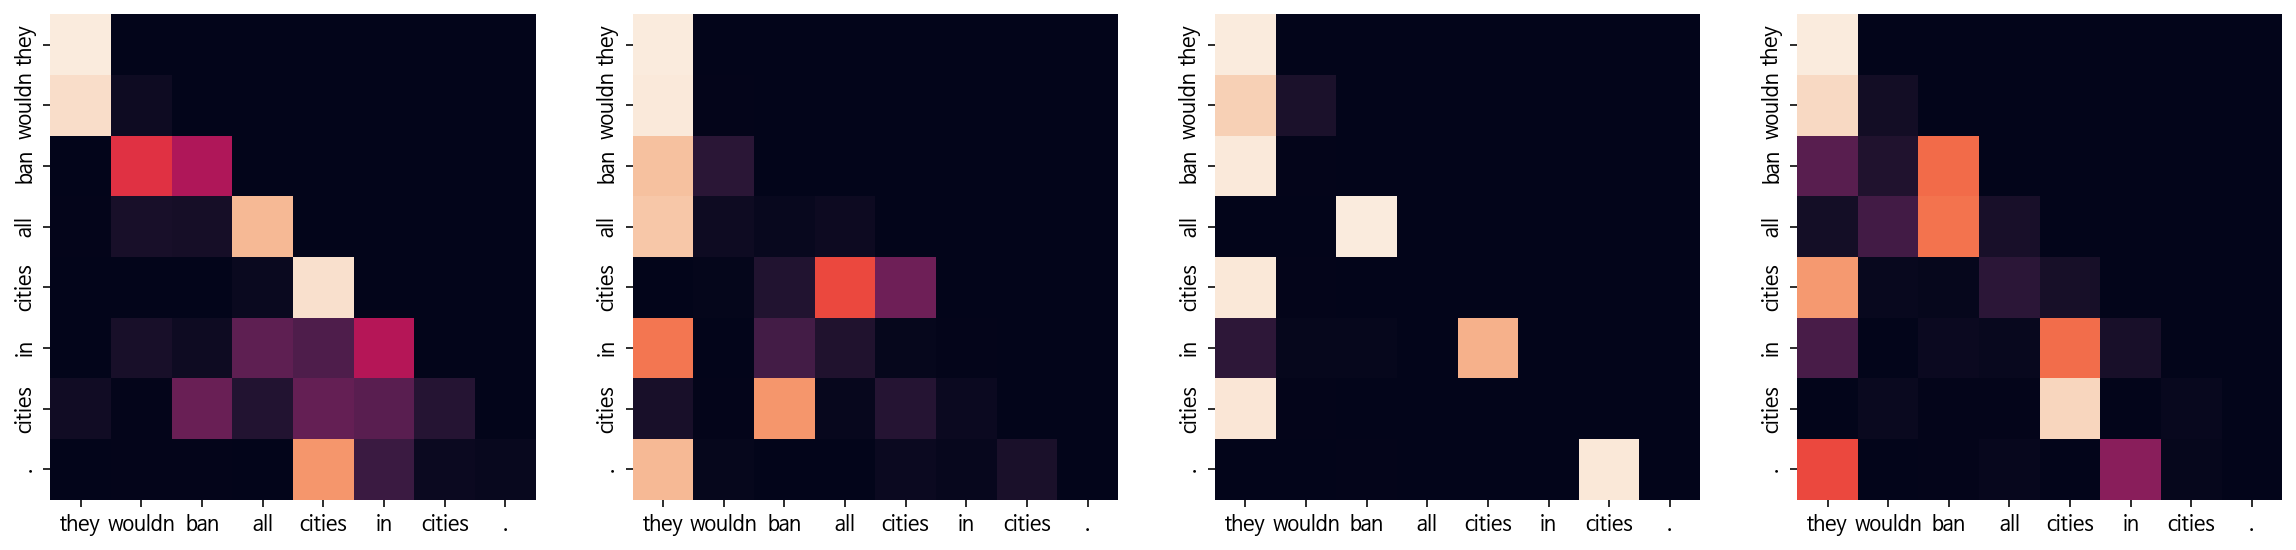

Decoder Src Layer 1


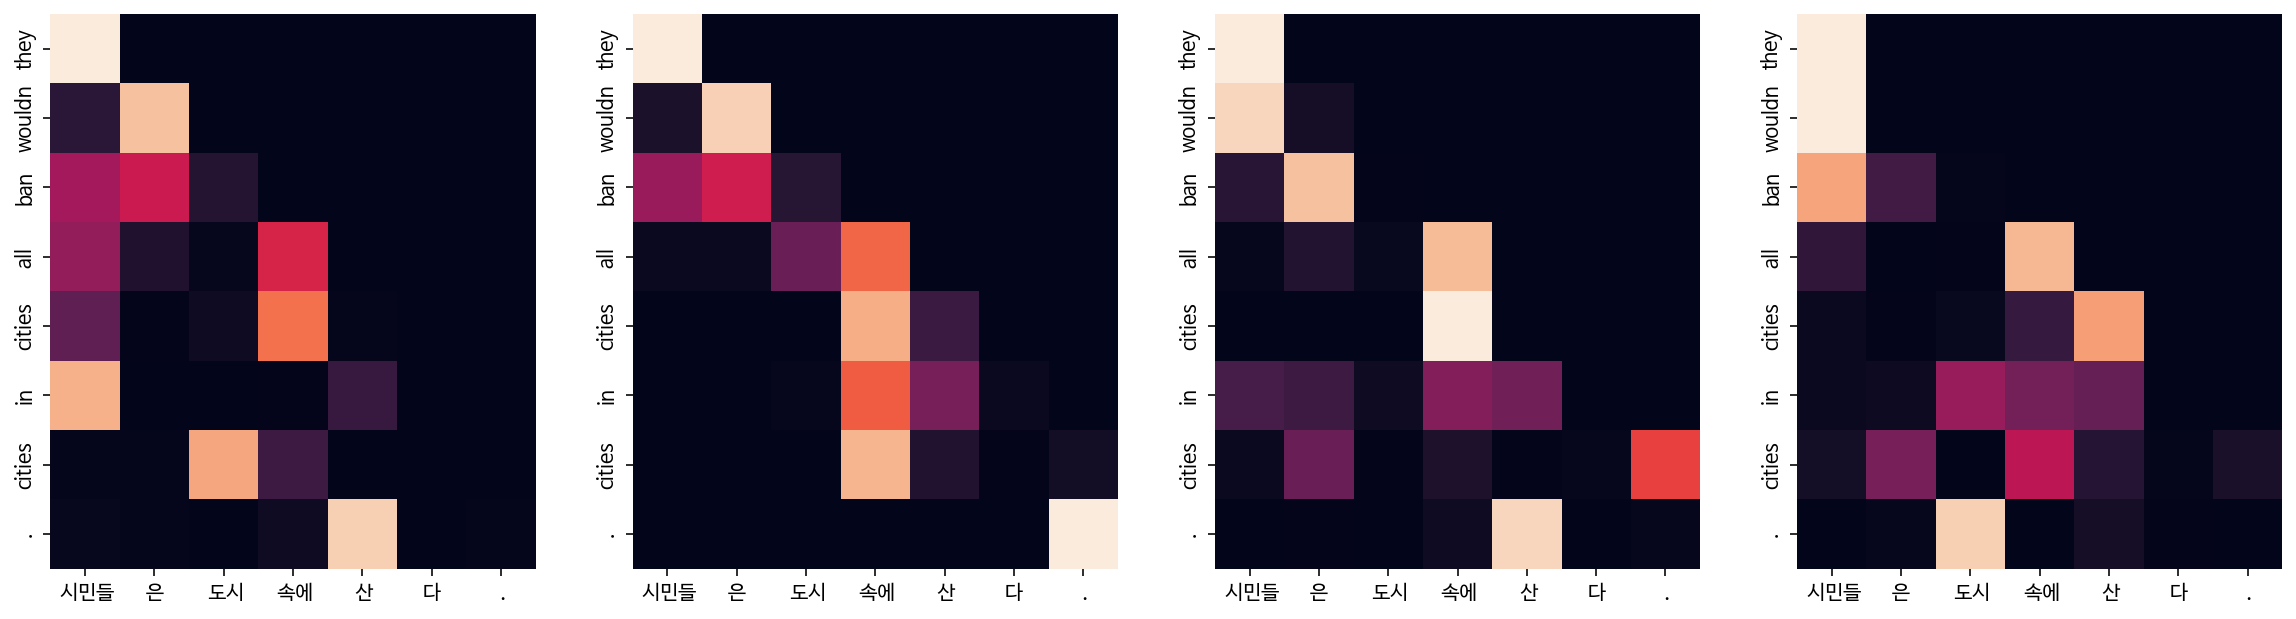

Decoder Self Layer 2


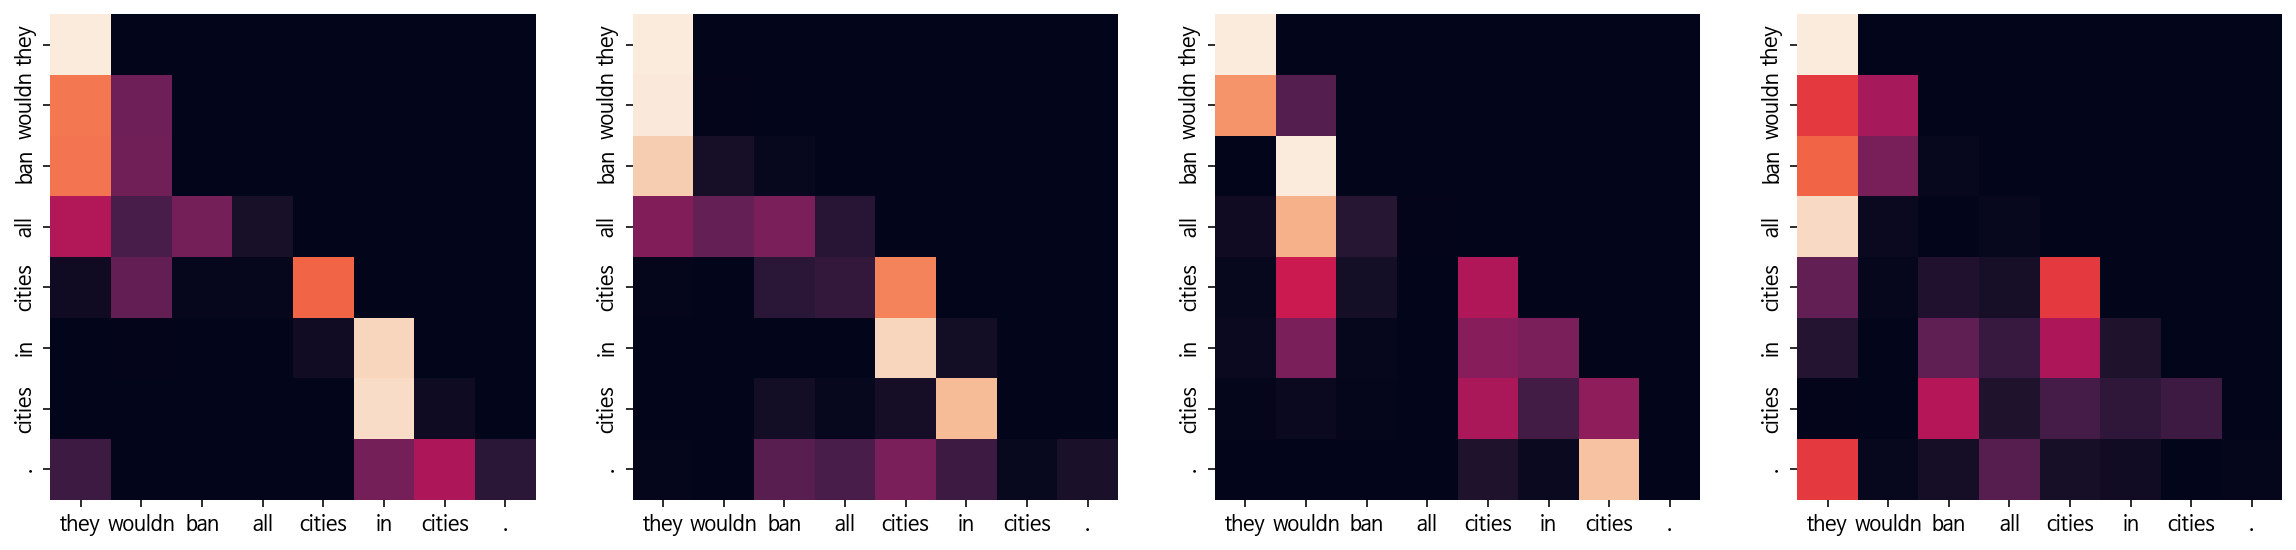

Decoder Src Layer 2


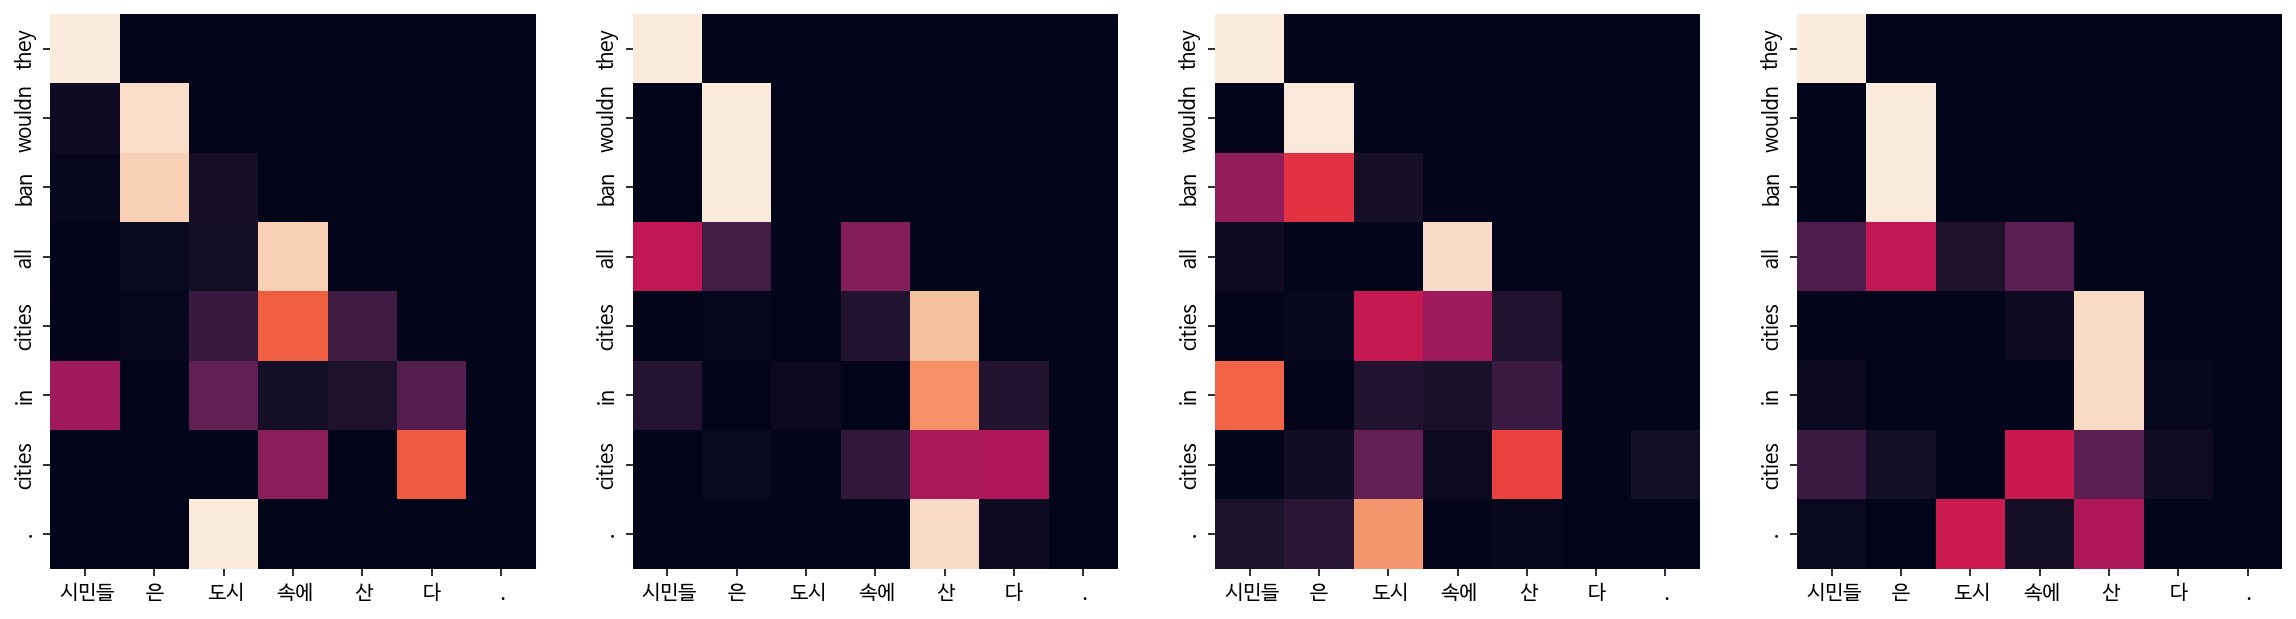

Input: 커피는 필요 없다.
Predicted translation: the practice needs to flight .
Encoder Layer 1


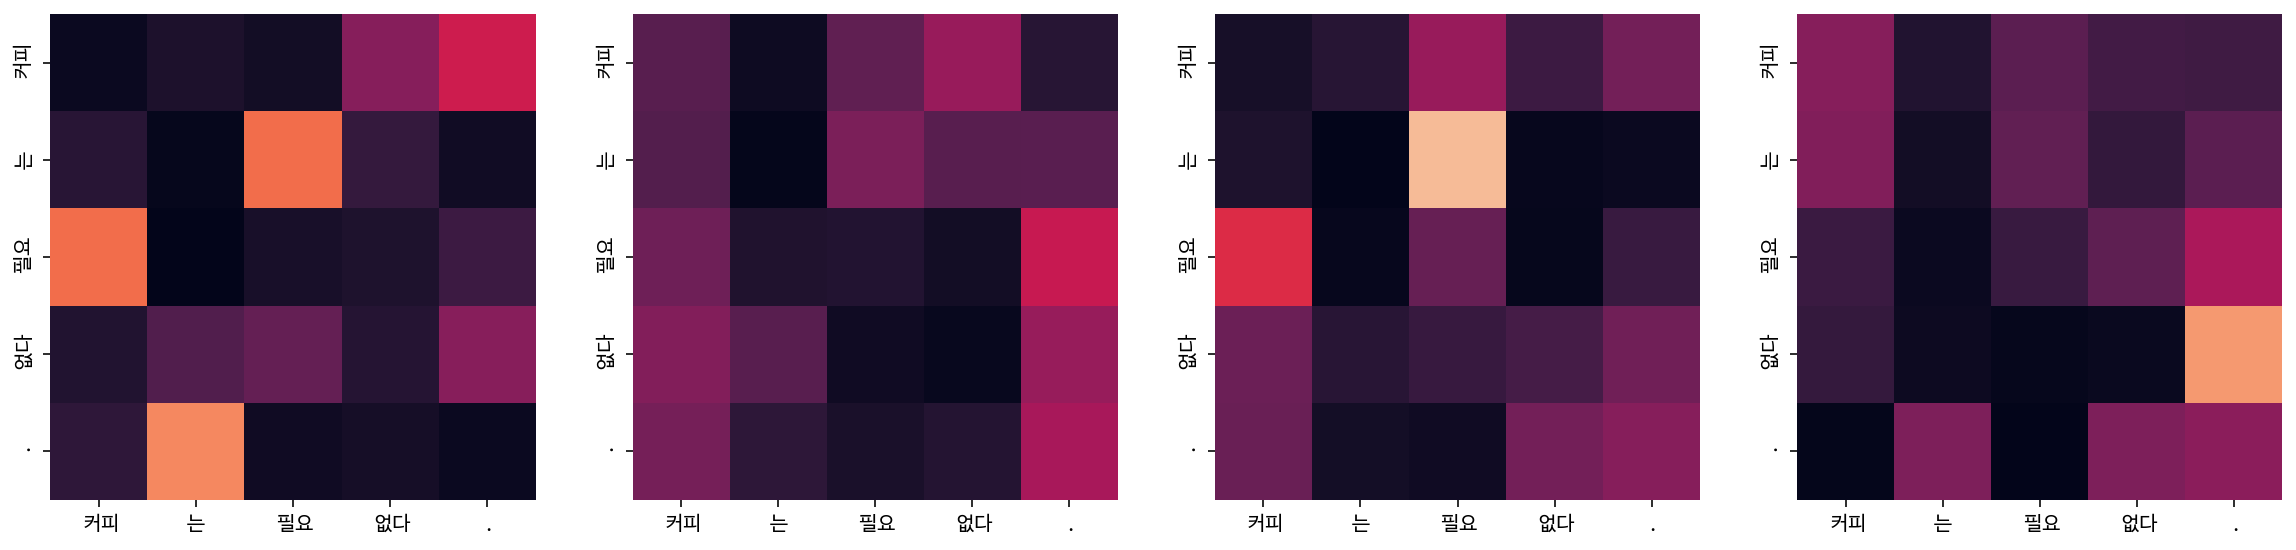

Encoder Layer 2


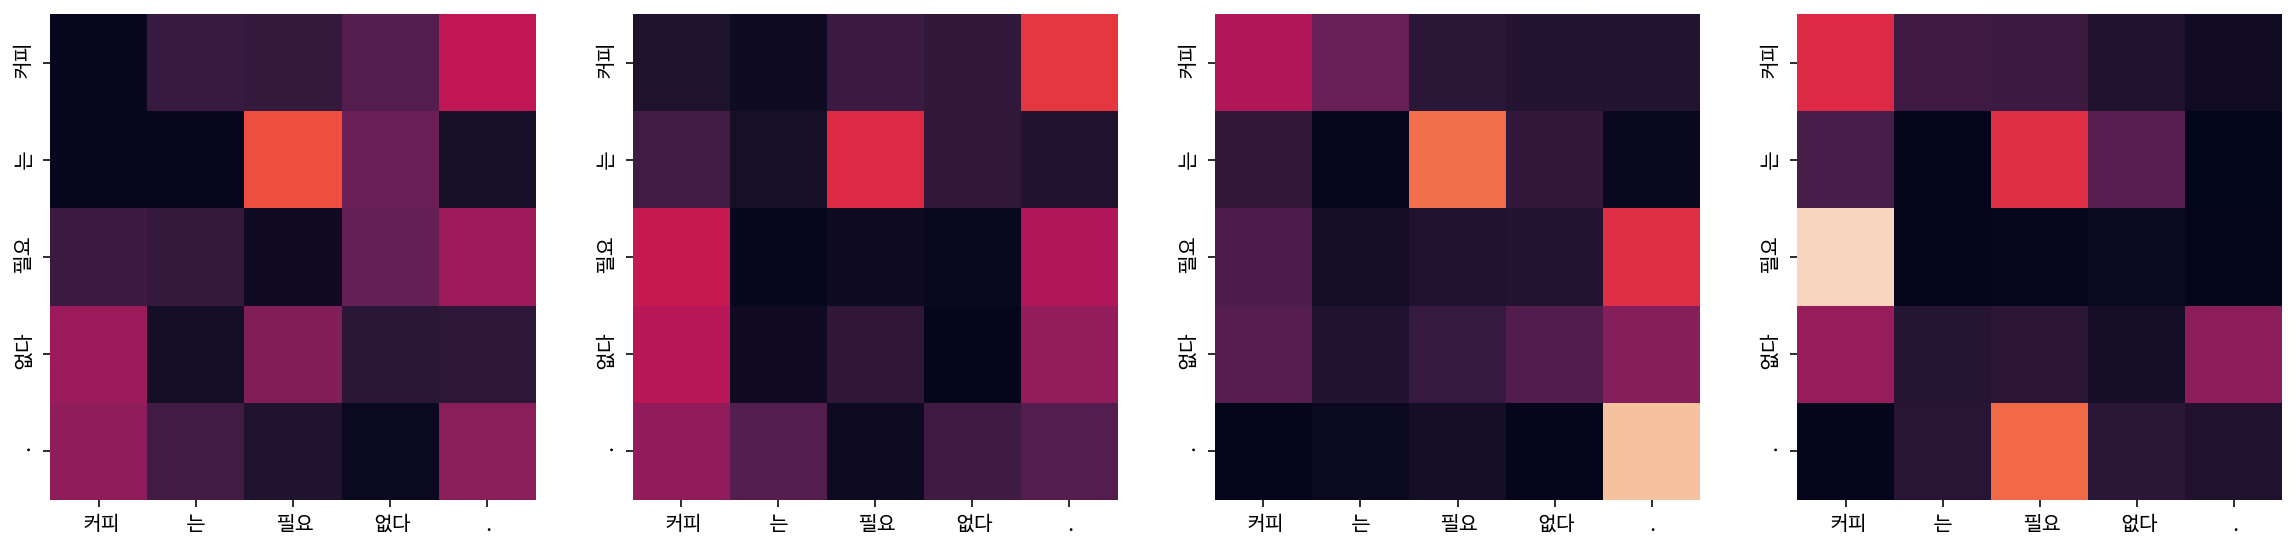

Decoder Self Layer 1


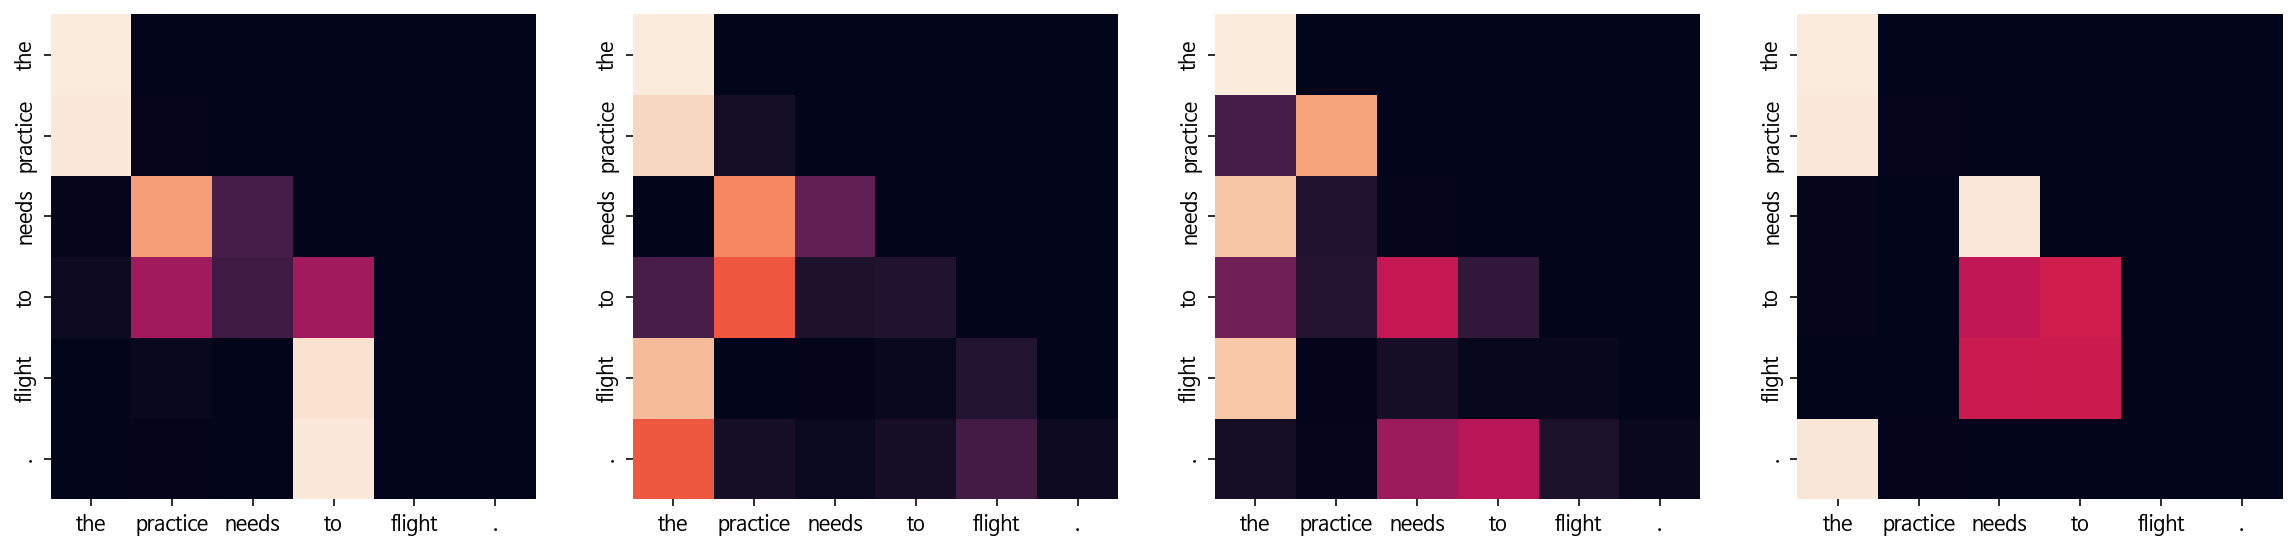

Decoder Src Layer 1


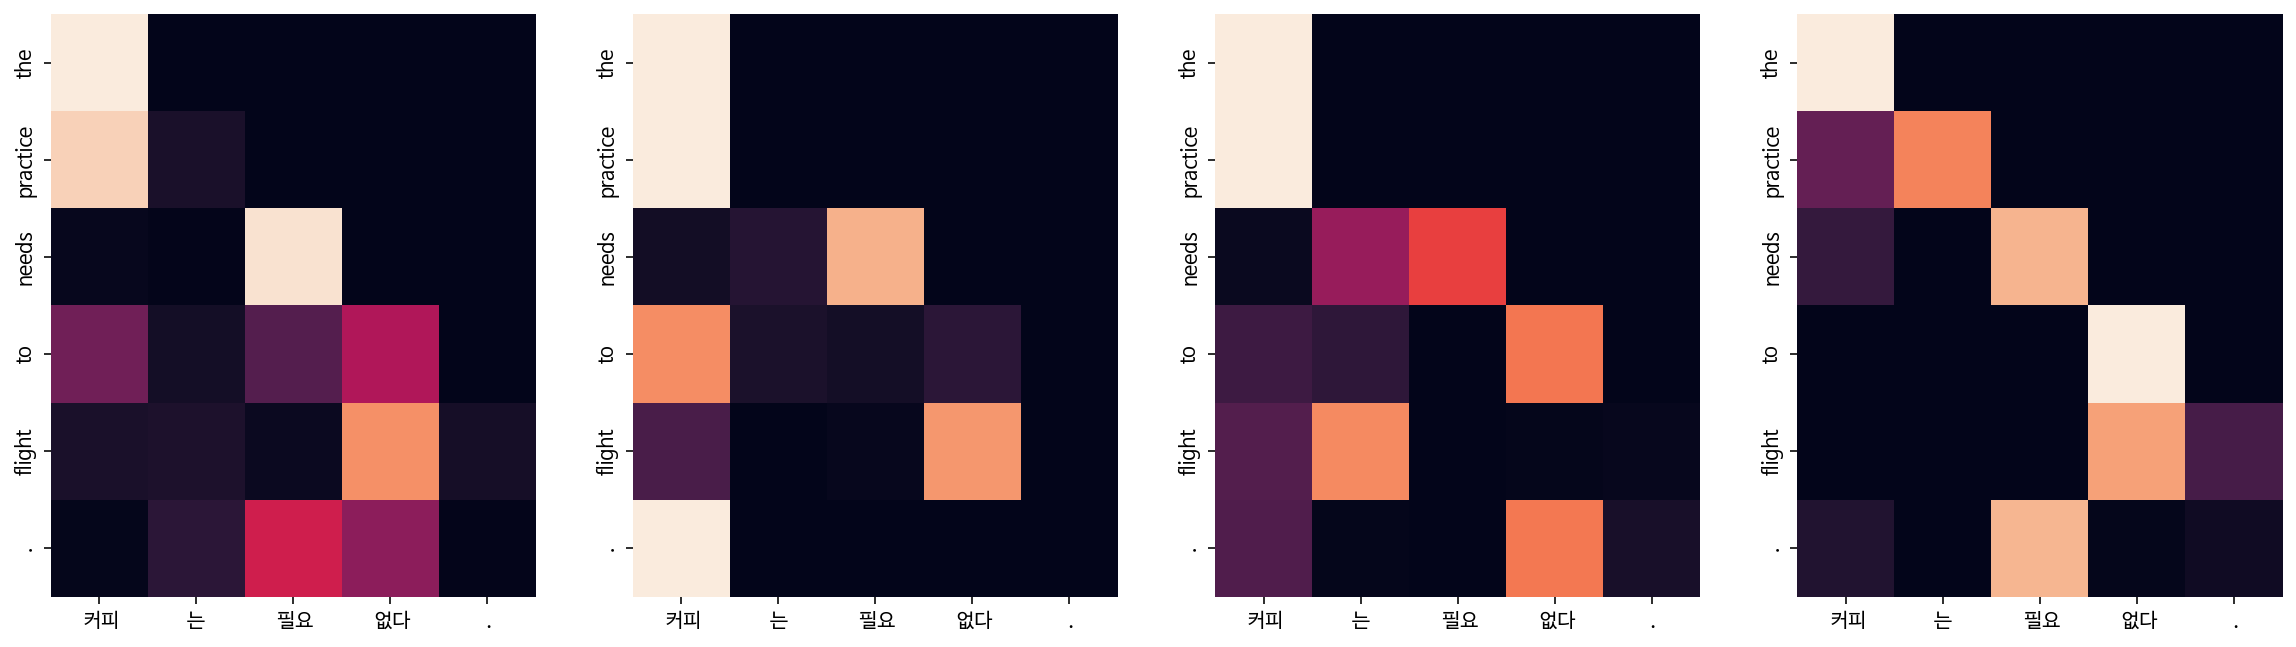

Decoder Self Layer 2


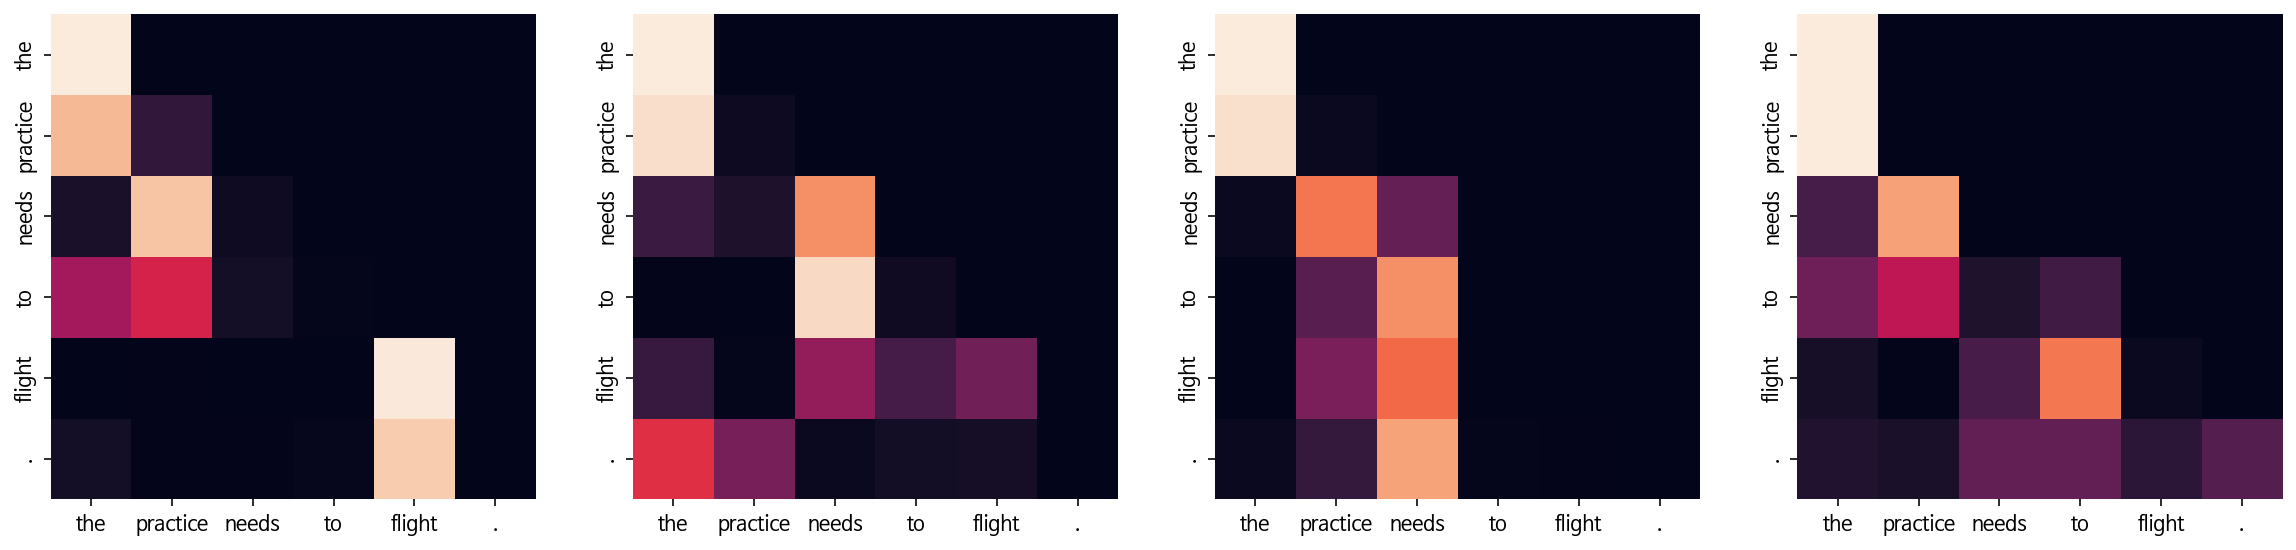

Decoder Src Layer 2


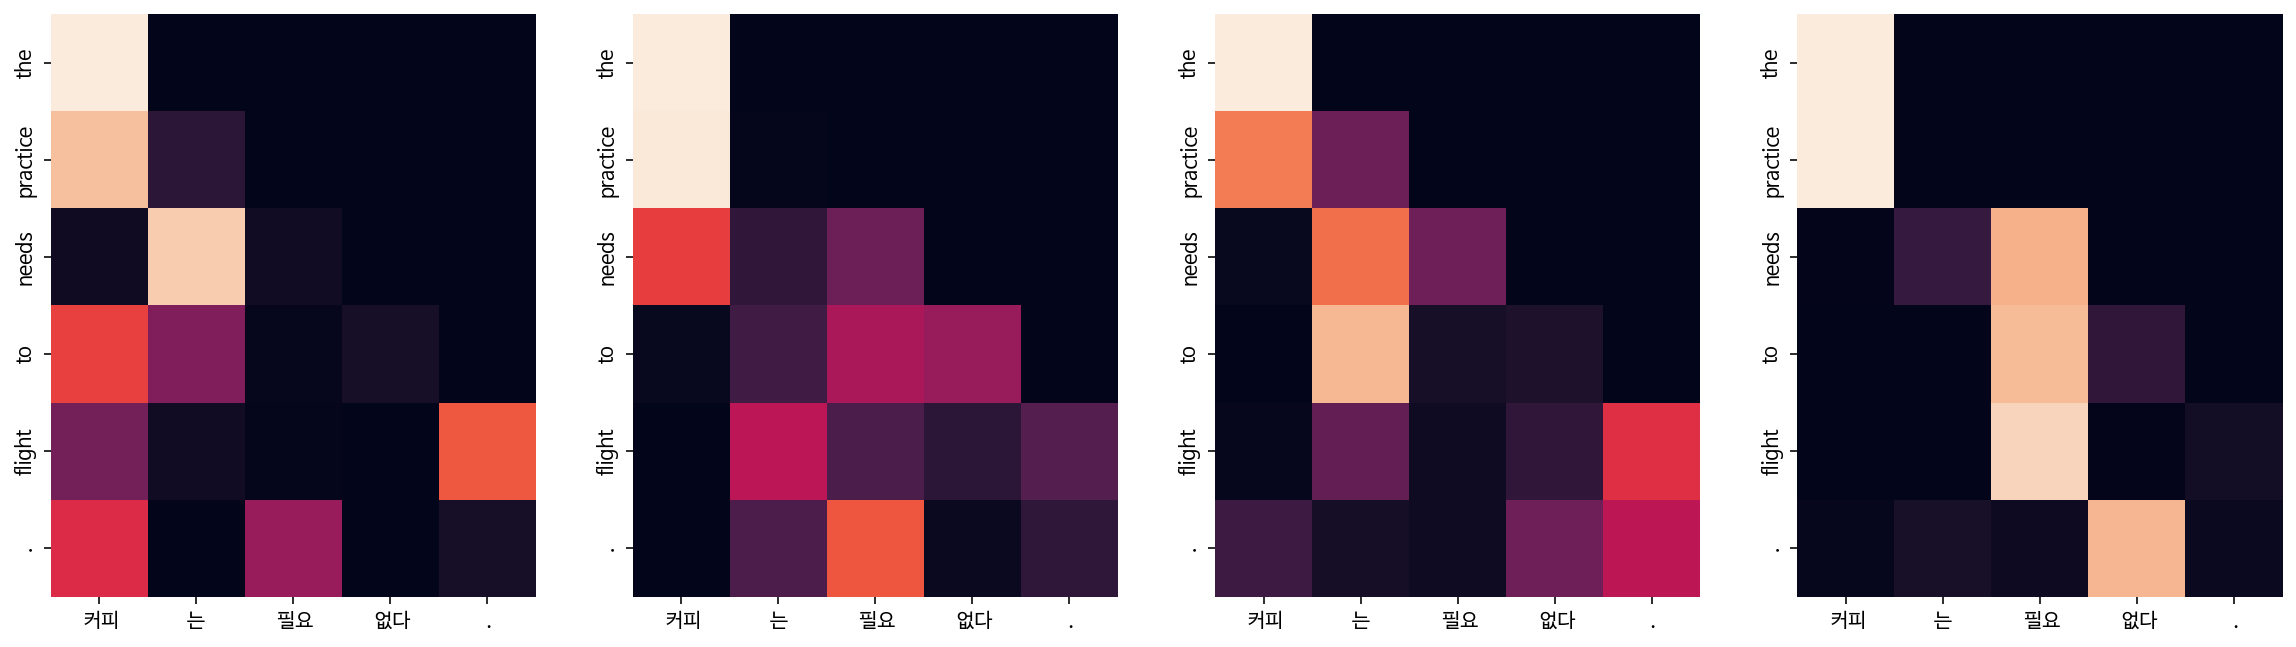

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people received seven deaths .
Encoder Layer 1


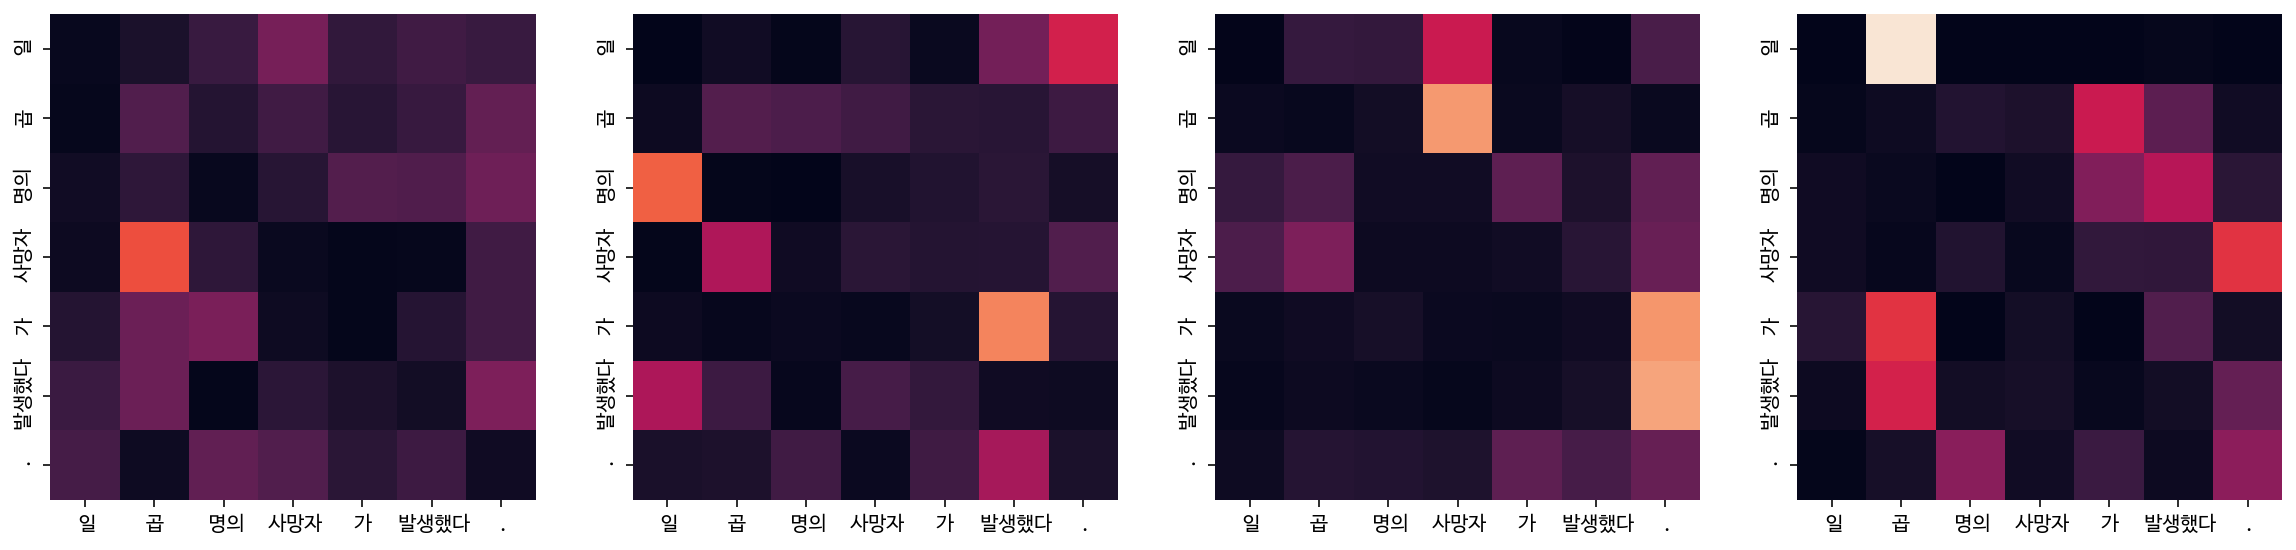

Encoder Layer 2


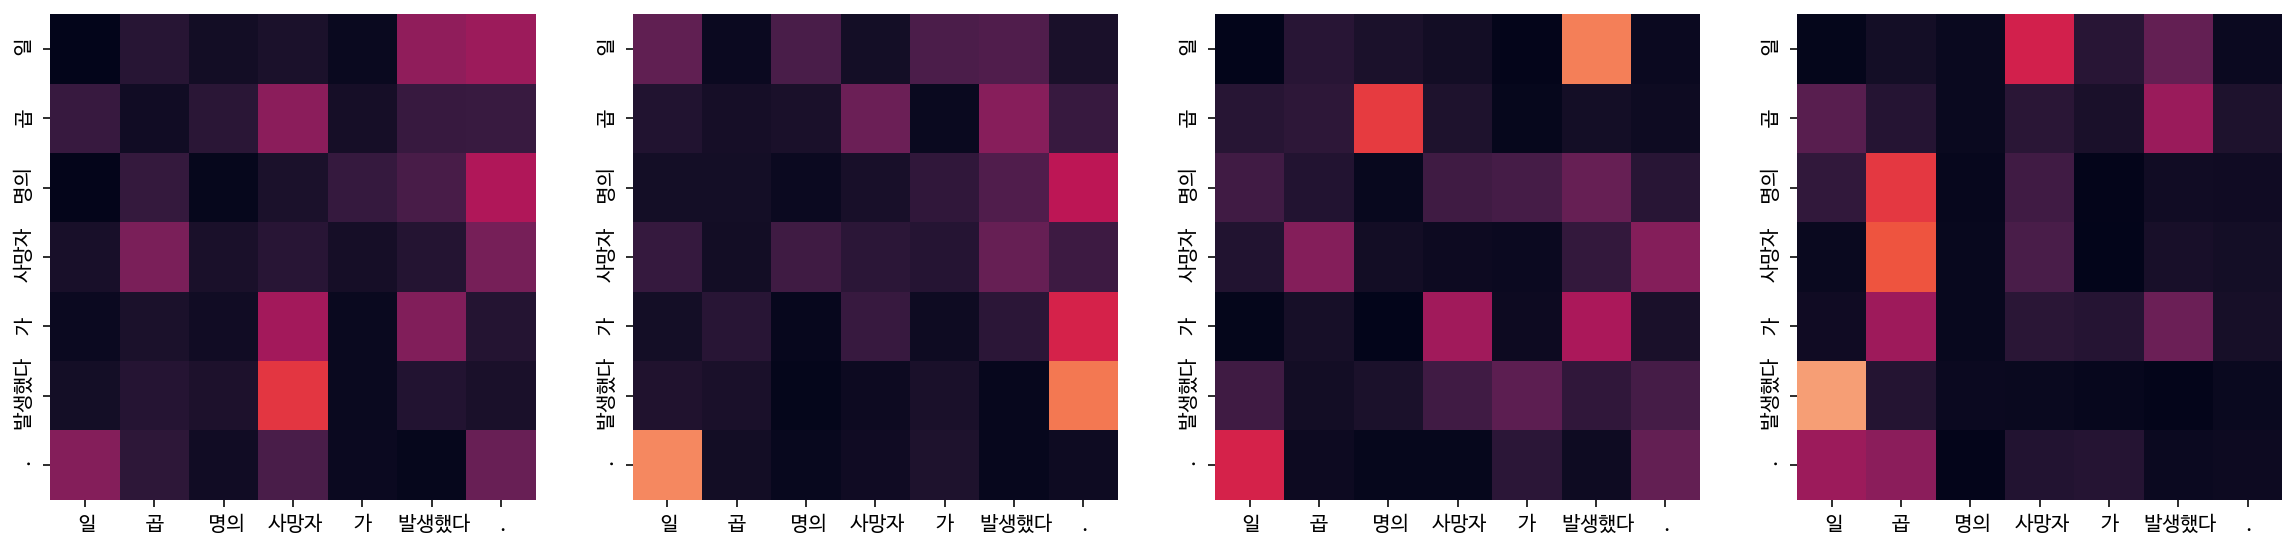

Decoder Self Layer 1


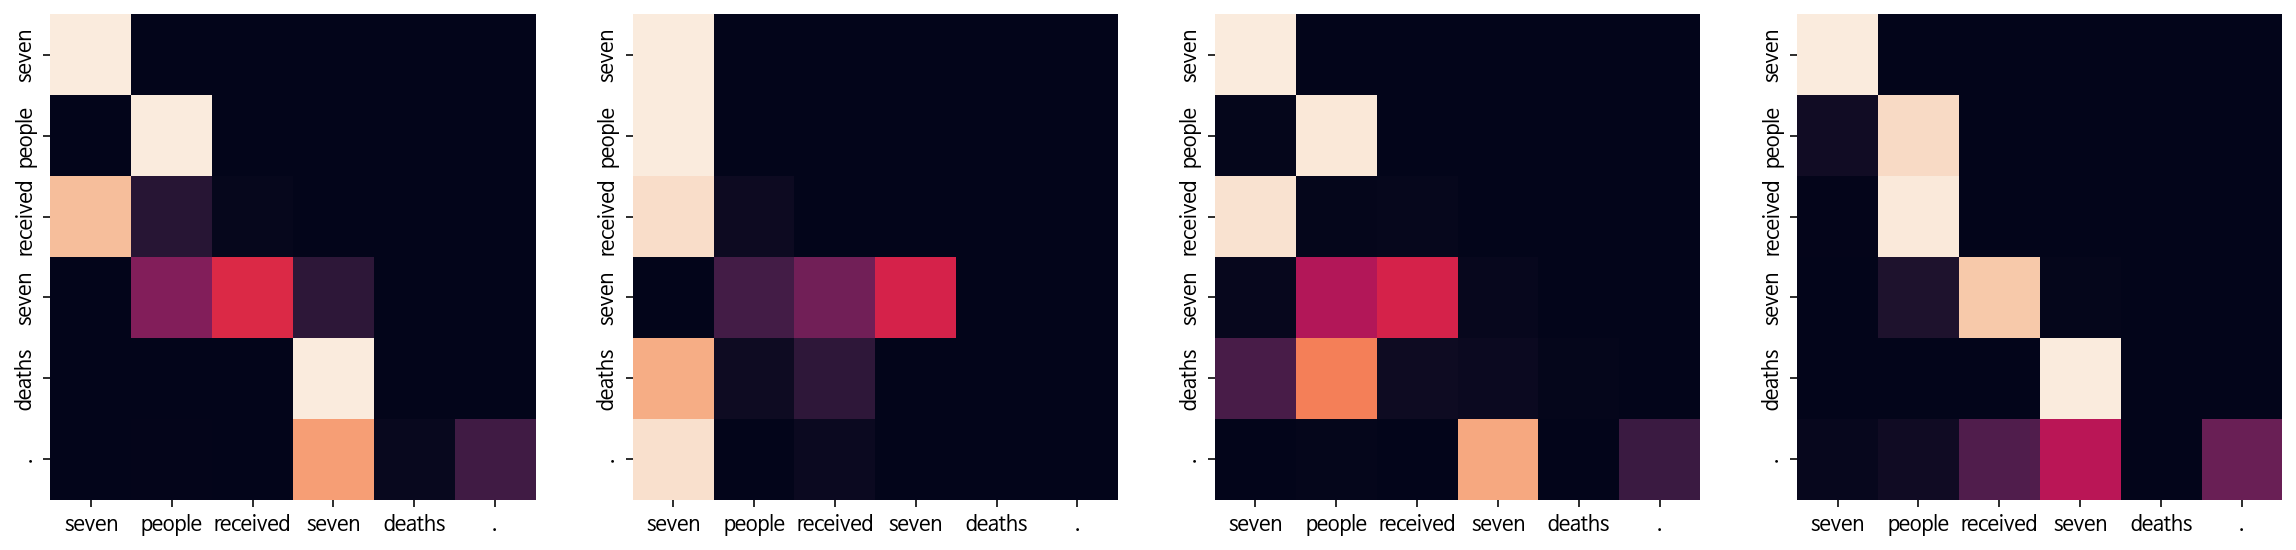

Decoder Src Layer 1


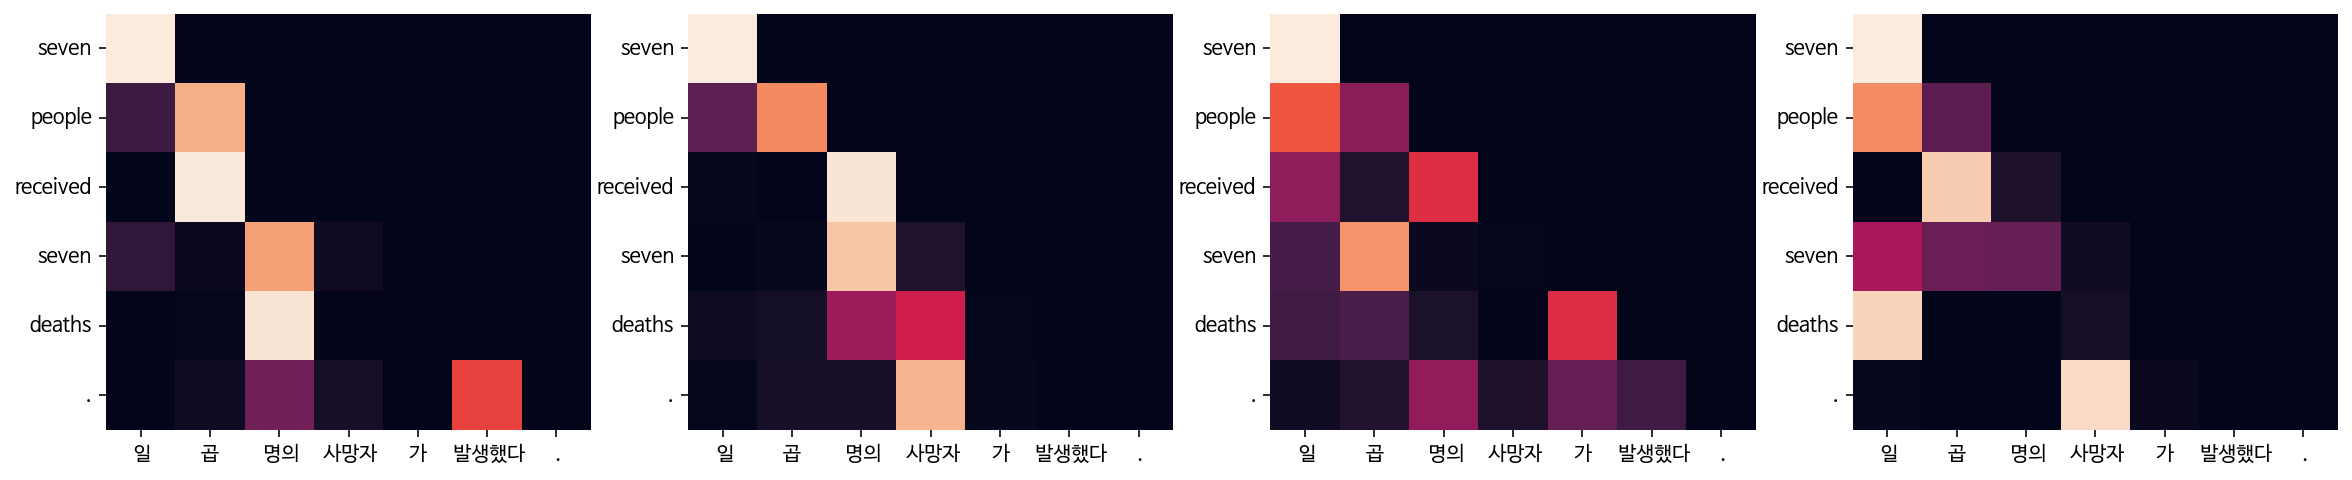

Decoder Self Layer 2


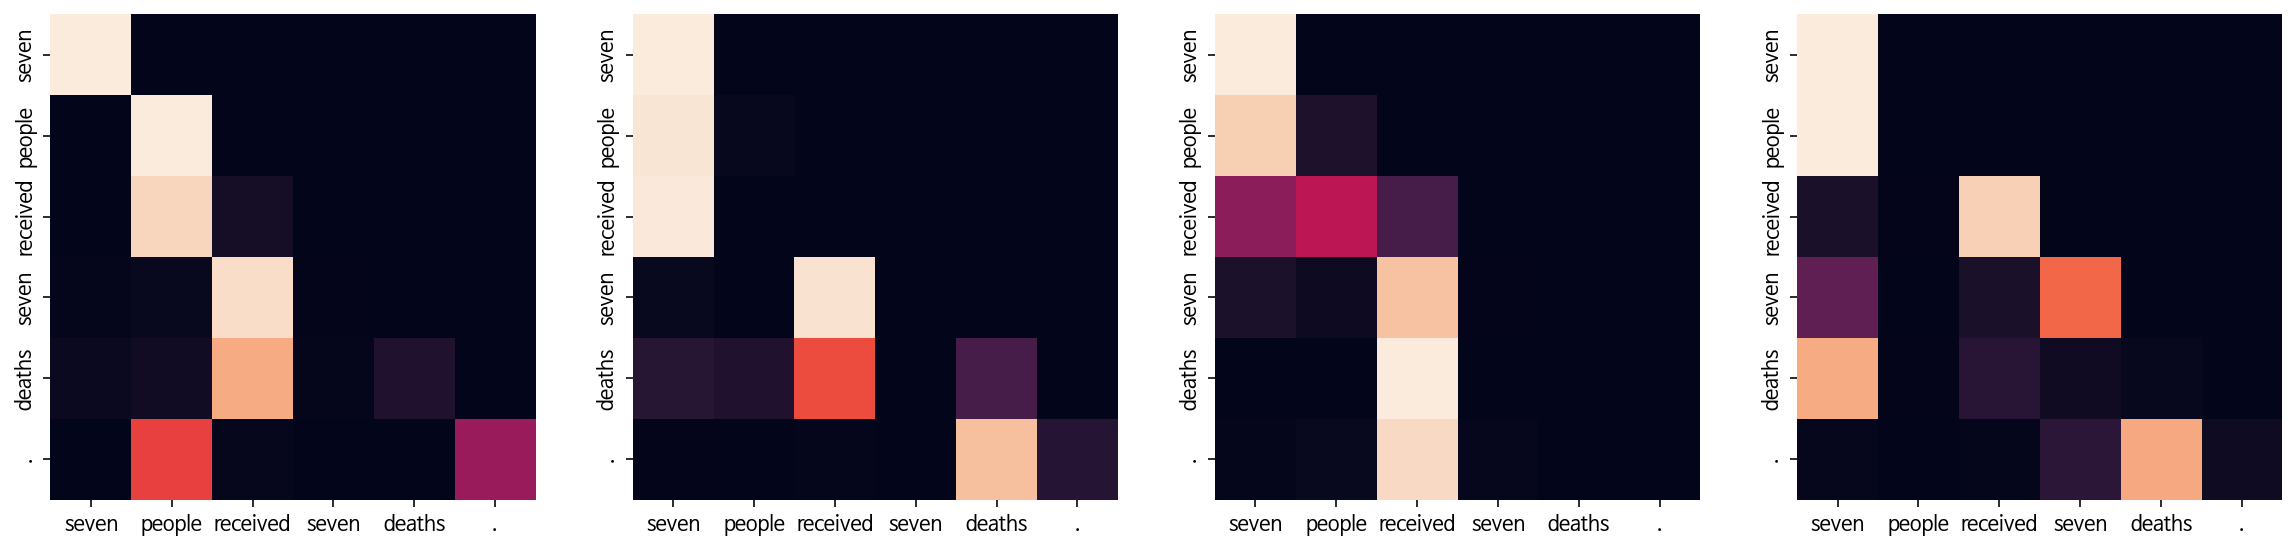

Decoder Src Layer 2


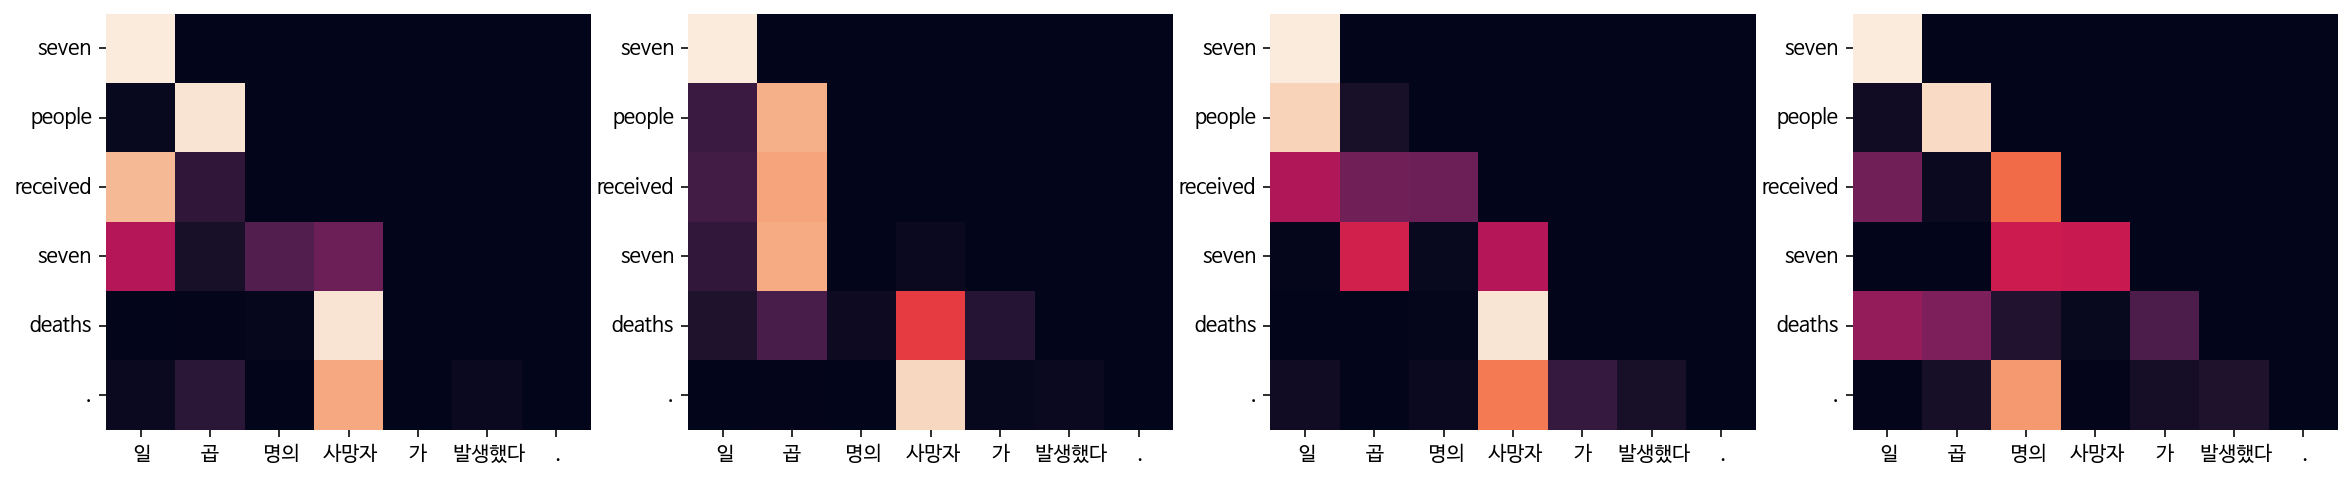

In [ ]:
# 어텐션 시각화를 포함하여 번역

for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# 회고

이번 노드에서는 트랜스포머를 활용해 번역기를 만들었다. 이를 위해 다양한 모듈을 미리 정의하여 이것들을 결합하는 방식을 사용했다. 인코더와 디코더 역시 클래스로 정의하고 동적으로 레이어를 쌓는 방식을 사용했다. 이 덕분에 트랜스포머는 원하는 만큼 레이어를 자유롭게 쌓을 수 있게 되었다.

그 외에도 마스킹이나 학습률에 대한 것들도 모듈화하였고, 학습률을 고정치가 아닌 가변적인 값을 쓸 수 있게 해주었다. 학습률은 학습 정도에 따라 그 적절한 수치가 계속해서 바뀌는데 가변적인 값으로 항상 적합한 수치로 넣어줌으로써 학습효율을 증가시킬 수 있다. 옵티마이저는 가장 보편적인 adam으로 하였다.

그렇게 학습 후 번역을 시도한 결과 문장들을 보니 "커피는 필요 없다." 가 "the practice needs to flight ." 로 번역된 것을 제외하면 나머지는 꽤나 나쁘지 않게 이루어졌다. 물론 완벽하게 내용이 일치하지는 않았지만 어텐션을 시각화하고 보니 나름 뜻이 통하는 단어끼리 잘 연결된 것을 확인할 수 있었다. 그리고 에폭이 진행될수록 로스 역시 지속적으로 내려가고 있었기 때문에 학습은 성공적이라고 할 수 있겠다.

하지만 여전히 완벽한 번역이라고 보기는 어려웠는데 이는 데이터의 부족과 학습 모델이 그렇게까지 깊지 않았기 때문이라고 생각한다. 저번 노드에 비해서는 더 많은 데이터를 사용하긴했으나 여전히 7만개 정도의 수는 충분한 수치가 아니었다. 그리고 학습 시간을 고려하여 모델을 깊지 않게 만들었으므로 성능에 한계가 있었을 것이다. 만약 데이터의 수가 더 늘어나고, 모델도 깊은 상태에서 적절한 학습을 진행했다면 더 나은 성능의 번역기가 되었겠지만 그만큼 학습속도가 매우 느렸을 것이다.

# Reference

https://reniew.github.io/43/ 어텐션

